# MCMC analysis #

© Pablo Jimeno - 2018

Code to perform MCMC sampling of the posterior probability distribution of the model parameter space.
* In a fresh new run, chains are created, saved and updated sequentially in the `chains_dir` folder.
* Chains can be stopped anytime, and progress to that moment will be stored.
* If a chain already exists, it will be loaded and continued unless stated otherwise (setting `new_MCMC_run = True`).
* Visual inspection of the chain will be produced each time the chain is stopped or when finished.
* Statistical code to analyze the chains is also included at the end of the notebook.

### Initialization

* Import code packages.
* Set working directory `working_dir`.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import style_plots
plt.style.use(style_plots.style)
%matplotlib notebook
from scipy.optimize import minimize
from scipy.special import logsumexp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import emcee
from getdist import plots, MCSamples
from utilities_mcmc_analysis import *


#working_dir = '/path/to/working/dir'
working_dir = os.getcwd()

### Load & plot data

Feel free to modify the code so your data fits the final `data` tuple containing the values: `(x_column, y_column, y_err_column)`
* To generate mock data, run the mock data generator: `%run {working_dir}/mock_data_generator.ipynb`
* In the code below, columns in the data file correspond to: [ id, x, y, $\sigma_y$ ].

The `plot_data` function assumes the first input_data is unidimensional (i.e., values in x). If this is not the case, feel free to modify the code or just ignore it.

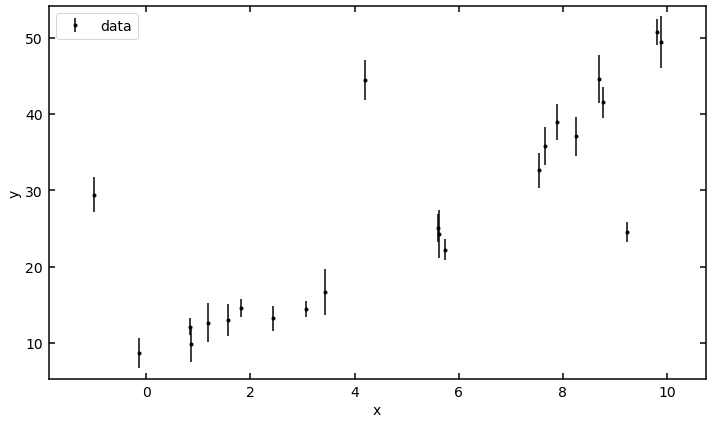

In [2]:
#data_file = 'path/to/data/file.csv'
data_file = 'mock_data.csv'

raw_data = pd.read_csv(data_file).as_matrix()

input_data = [raw_data[:,1]]
y_data = (raw_data[:,2], raw_data[:,3])

data = (input_data, y_data)

plot_data(None, data, save=False)

### MCMC Configuration
MCMC run configuration:
1. `chain_name` (string): the "name" of the mcmc run.
2. `new_MCMC_run` (bool): if set to `True`, any previous chain run will be deleted and a new one will be created.

Chain configuration:
1. `nwalkers` (int): number of independent walkers in the mcmc run.
2. `nsteps` (int): number of steps each walker will give before completion.
3. `nthreads` (int): number of threads to be used in parallel by the CPU.
4. `stepsave` (int): number of steps between each chain save.

Processing configuration:
1. `process_chain` (bool): if set to `True` the chain will be processed when stopped.
2. `burning_fraction` (float): the fraction of the chain to be burned in the statistical analysis.

In [3]:
chain_name = 'test'
new_MCMC_run = True

nwalkers = 400
nsteps = 2000
nthreads = 4
stepssave = 200

process_chain = True
burning_fraction = 0.33

#================================================================================
## Initialize MCMC configuration & set options:
mcmc_config = MCMCConfiguration(working_dir, chain_tag=chain_name, redo_MCMC=new_MCMC_run)

mcmc_config.set_nwalkers(nwalkers)
mcmc_config.set_nsteps(nsteps)
mcmc_config.set_nthreads(nthreads)
mcmc_config.set_stepssave(stepssave)
mcmc_config.set_process_chain(process_chain)
mcmc_config.define_burning(burning_fraction)

### Function modeling

1. Define the model function `model_function` used in the likelihood function to evaluate `y_model`.

    * This function can be as complex as desired, and may depend in more than one input variable $x_1, \dots, x_n$. Just make sure that the first arg corresponds to the `input_data` from `data`, and the rest of args correspond to the parameters that we are trying to sample through the MCMC analysis.
    
    * In the example below, model_function depends on just one input value `x`, and 3 parameters: `(A, B, C)`.
    
2. Define the names (`param_names`) and the labels (`param_labels`) for the parameters to be sampled by the MCMC.

3. Set an starting point (`param_guess`) to optimize the search for the point from where the MCMC walkers will start exploring. This step is not crucial as the code will improve your guess automatically through `scipy.minimize` function.

4. Set the priors (`param_priors`) for the parameters.
    * `param_priors[i] [0]`: type of prior to be used.
        * Options are `'flat'`(flat uniform prior), `'flatlog'`(flat uniform prior on the log), and `'normal'` (normal Gaussian prior).
    * `param_priors[i] [1]`:
        * In case of 'flat' or 'flatlog': the minimum parameter value.
        * In case of 'normal': the mean of the Gaussian prior.
    * `param_priors[i] [2]`:
        * In case of 'flat' or 'flatlog': the maximum parameter value.
        * In case of 'normal': the $\sigma$ of the Gaussian prior.
    

In [4]:
def model_function(input_data, A, B, C):
    x1 = input_data[0]
    return A + B*x1 + C*x1**2

param_names = ['A', 'B', 'C']
param_labels = ['A', 'B', 'C']

param_guess = [10., 1., 0.4]

param_priors = [
    ('flat', -200., 200.), # A prior
    ('flat', -200., 200.), # B prior
    ('flat', -200., 200.) # C prior
]

#================================================================================
## Set global parameter information:
param_info = (param_names, param_labels, param_guess, param_priors)

### Plot data

Print the data and the initial guess model.
* You can use this to adjust your param_guess.

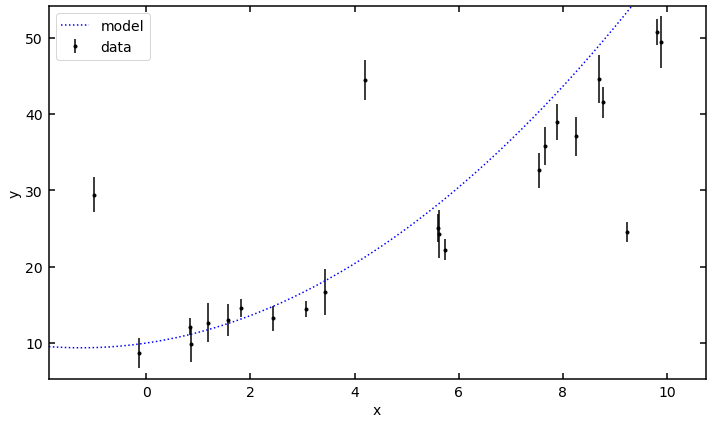

In [5]:
plot_data(None, data, include_model_func=model_function, model_params=param_guess, save=False)

### Run MCMC code

1. Append the "outlier distribution" parameters needed to run the code.
2. Run the MCMC sampling code and get the chain info. You can stop the chain in any moment; just remember to set `new_MCMC_run` to `False` if you want to continue with this chain in the next run.
3. Burn the chain and obtain maximum likelihood parameters.


Initializing new MCMC chain...

100.00% (2000 of 2000 steps)

Chain saved at: "/home/pablo/Proyectos/mcmc_analysis/mcmc_chains/mcmc_chain_test.pickle"

Completed chain shape: (400, 2000, 6)
# walkers: 400
# steps: 2000

Plotting MCMC chain evolution...


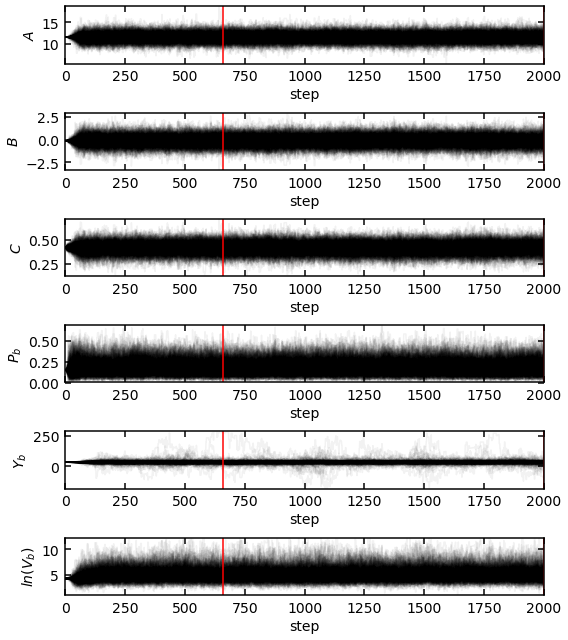


"MCMC_evolution_test" plot saved in: "/home/pablo/Proyectos/mcmc_analysis/output_plots"

MCMC chain finished.



In [6]:
param_info_wod = append_outlier_dist_info(param_info, data)

mcmc_chain, mcmc_lnpro = mcmc_analysis(mcmc_config, data, model_function, param_info_wod)

### Burn the chain to continue with the statistical analysis

In [7]:
burned_chain, theta_ml = burn_chain(mcmc_config, mcmc_chain, mcmc_lnpro)


Burning 67.0% of MCMC chain...
Initial chain shape: (400, 2000, 6)

Chain burned.
Burned chain shape: (536000, 6)


### Plot the posterior probability parameter space

Plot the posterior probability parameter space distribution.
* The maximum likelihood point is marked with a star and vertical red lines.


Processing MCMC chain...
Removed no burn in


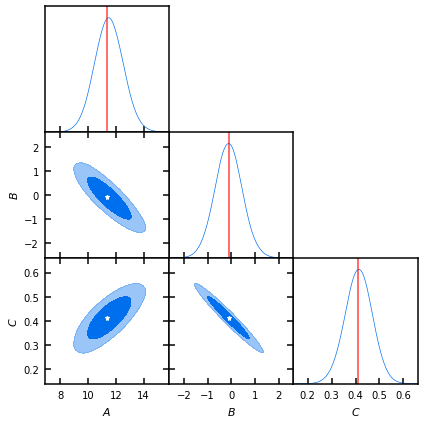


"MCMC_sampling_test" plot saved in: "/home/pablo/Proyectos/mcmc_analysis/output_plots"


In [8]:
plot_sampling(mcmc_config, param_info_wod, burned_chain, theta_ml, include_outlier_dist=False, include_ml=True)

### Plot MCMC chain sampling
Plot the resulting MCMC sampling of the posterior probability space.
* Each black line is obtained sampling from the MCMC chain.
* The "best fit" maximum likelihood point obtained from the chain is plotted as the red line.
* Detected outliers are marked with red circles.

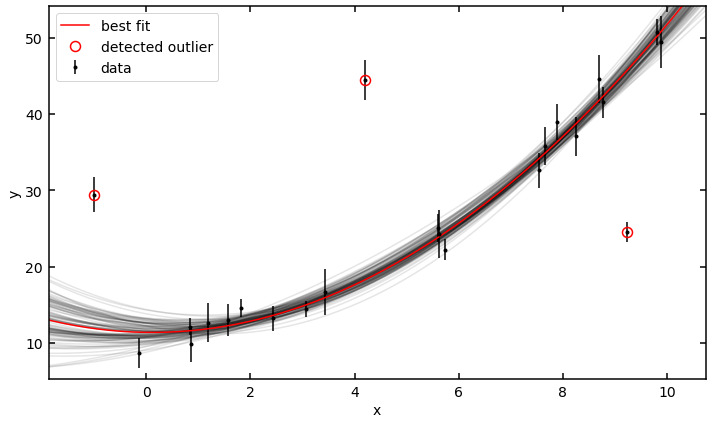


"MCMC_sampling_test" plot saved in: "/home/pablo/Proyectos/mcmc_analysis/output_plots"


In [9]:
plot_mcmc_results(mcmc_config, burned_chain, theta_ml, data, model_function, param_info_wod, nsamples=100)

### Plot obtained MCMC model

Plot the resulting model with 1$\sigma$ errors, obtained sampling from the MCMC chain.

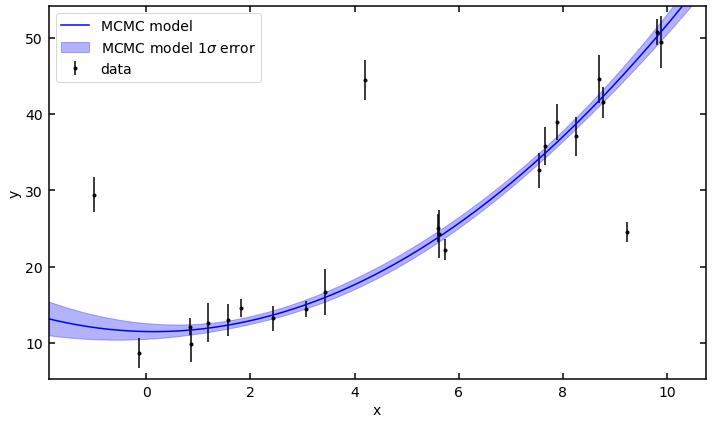


"MCMC_model_test" plot saved in: "/home/pablo/Proyectos/mcmc_analysis/output_plots"


In [10]:
plot_mcmc_model(mcmc_config, burned_chain, data, model_function)

### Display results

Display the results obtained from the burned chain analysis.
* The last 3 parameters, "Pb", "Yb" and "lnVb", correspond to the outlier model distribution.

In [11]:
display_results(burned_chain, param_info_wod)

,mean,<error>,- error,+ error,value ±,value ± (latex),value -+,value -+ (latex)
A,11.499181,1.032260,1.025431,1.039090,11.50 ± 1.03,11.50 \pm 1.03,11.50 -1.03 +1.04,11.50_{-1.03}^{+1.04}
B,-0.117485,0.575413,0.574417,0.576408,-0.12 ± 0.58,-0.12 \pm 0.58,-0.12 -0.57 +0.58,-0.12_{-0.57}^{+0.58}
C,0.413417,0.057194,0.057538,0.056850,0.41 ± 0.06,0.41 \pm 0.06,0.41 -0.06 +0.06,0.41_{-0.06}^{+0.06}
Pb,0.175026,0.082443,0.071387,0.093499,0.18 ± 0.08,0.18 \pm 0.08,0.18 -0.07 +0.09,0.18_{-0.07}^{+0.09}
Yb,32.157324,7.130029,7.215532,7.044527,32.16 ± 7.13,32.16 \pm 7.13,32.16 -7.22 +7.04,32.16_{-7.22}^{+7.04}
lnVb,4.875388,1.092447,0.957334,1.227560,4.88 ± 1.09,4.88 \pm 1.09,4.88 -0.96 +1.23,4.88_{-0.96}^{+1.23}
